# Raw Analytics - Acidentes Aéreos

Análise de qualidade dos dados brutos da camada Bronze.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Carregamento


In [2]:
plt.style.use('seaborn-v0_8')
sns.set_theme(context="notebook", style="whitegrid")

df = pd.read_csv('data_raw.csv', sep=';')
df_temp = df.copy()

## 2. Dados Faltantes por Coluna


In [3]:
missing_data = pd.DataFrame({
    'Coluna': df.columns,
    'Nulos': df.isnull().sum().values,
    'Total': df.isnull().sum().values + (df == '').sum().values,
    '%': ((df.isnull().sum().values + (df == '').sum().values) / len(df) * 100).round(2)
})

missing_data = missing_data[missing_data['Total'] > 0].sort_values('Total', ascending=False)
missing_data


,Coluna,Nulos,Total,%
3,Latitude da Ocorrencia,1562,1562,25.55
4,Longitude da Ocorrencia,1562,1562,25.55
18,Ano de Fabricacao da Aeronave,182,182,2.98
17,Quantidade de Assentos na Aeronave,177,177,2.89
16,Aeronave Motor Tipo,3,3,0.05
19,Voo de Origem do Acidente,1,1,0.02
20,Voo Destino do Acidente,1,1,0.02


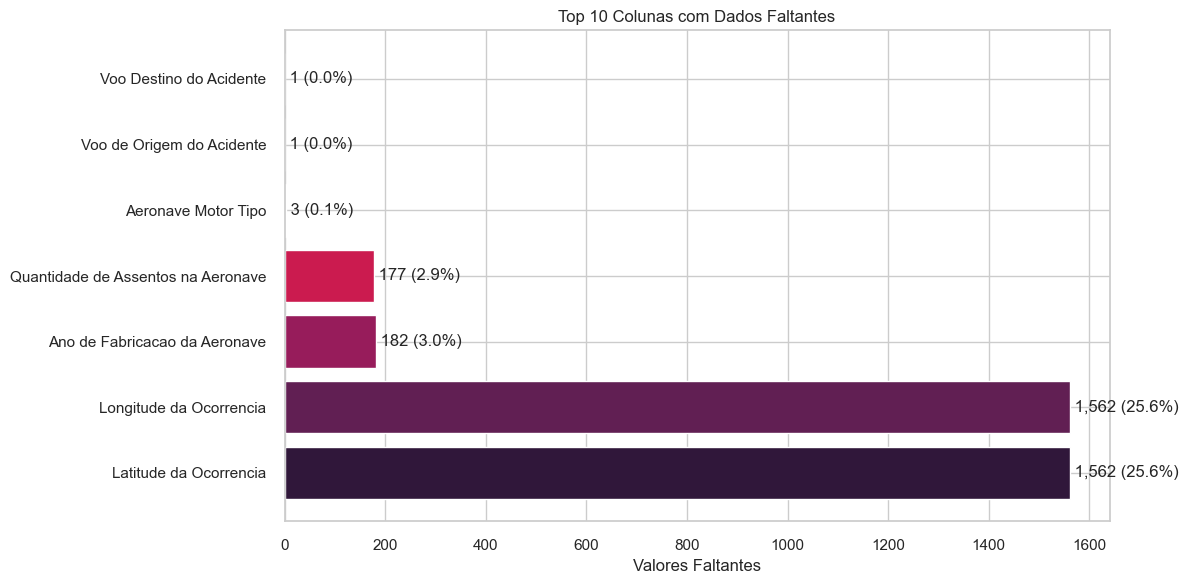

In [4]:
if len(missing_data) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    top_missing = missing_data.head(10)
    colors = sns.color_palette('rocket', n_colors=len(top_missing))
    
    ax.barh(top_missing['Coluna'], top_missing['Total'], color=colors)
    ax.set_xlabel('Valores Faltantes')
    ax.set_title('Top 10 Colunas com Dados Faltantes')
    
    for i, (idx, row) in enumerate(top_missing.iterrows()):
        ax.text(row['Total'], i, f" {row['Total']:,.0f} ({row['%']:.1f}%)", ha='left', va='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("Nenhum valor faltante significativo")


### Interpretação

**Por que este gráfico?** Um gráfico de barras horizontal é ideal para visualizar dados faltantes porque permite identificar rapidamente quais colunas têm mais problemas de qualidade. A ordem decrescente facilita a priorização de ações de limpeza de dados.

**Resultado:** Este análise revela quais campos do dataset estão mais incompletos. Colunas com alta porcentagem de valores faltantes podem comprometer análises posteriores e podem indicar:
- Dados não coletados em certos períodos
- Falhas no sistema de registro
- Campos opcionais ou nem sempre aplicáveis

**Ação:** Campos com muitos valores faltantes precisam ser tratados (imputação, exclusão de registros ou simplesmente ignorados na análise).

## 3. Evolução Temporal de Ocorrências


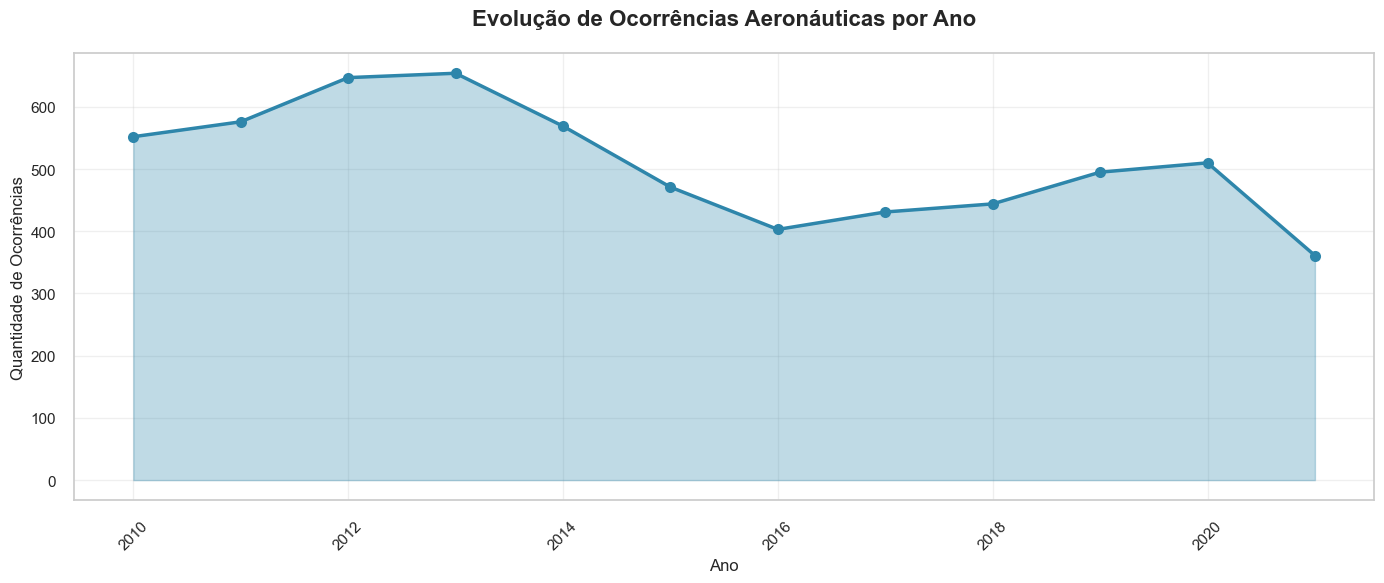

Ano com mais ocorrências: 2013 (654 ocorrências)


In [5]:
# Preparando dados temporais
df['Data e Hora da Ocorrencia'] = pd.to_datetime(df['Data e Hora da Ocorrencia'], format='%d/%m/%Y %H:%M', errors='coerce')
df['Ano'] = df['Data e Hora da Ocorrencia'].dt.year
ocorrencias_ano = df.groupby('Ano').size().reset_index(name='Quantidade')
ocorrencias_ano = ocorrencias_ano[ocorrencias_ano['Ano'].notna()]

# Gráfico
plt.figure(figsize=(14, 6))
plt.plot(ocorrencias_ano['Ano'], ocorrencias_ano['Quantidade'], marker='o', linewidth=2.5, markersize=8, color='#2E86AB')
plt.fill_between(ocorrencias_ano['Ano'], ocorrencias_ano['Quantidade'], alpha=0.3, color='#2E86AB')
plt.title('Evolução de Ocorrências Aeronáuticas por Ano', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Quantidade de Ocorrências', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Ano com mais ocorrências: {ocorrencias_ano.loc[ocorrencias_ano['Quantidade'].idxmax(), 'Ano']:.0f} ({ocorrencias_ano['Quantidade'].max()} ocorrências)")


### Interpretação

**Por que este gráfico?** Um gráfico de linha com preenchimento é perfeito para mostrar tendências temporais. Permite visualizar padrões, picos e quedas ao longo do tempo de forma clara e intuitiva.

**Resultado:** A análise temporal mostra:
- Se os acidentes aumentaram ou diminuíram ao longo dos anos
- Quais períodos foram mais críticos
- Possíveis causas externas (regulamentações, avanços tecnológicos)

**Insight:** A visualização pode revelar se houve melhorias na segurança aeronáutica ao longo dos anos ou se há períodos específicos com maior risco.

## 4. Classificação das Ocorrências


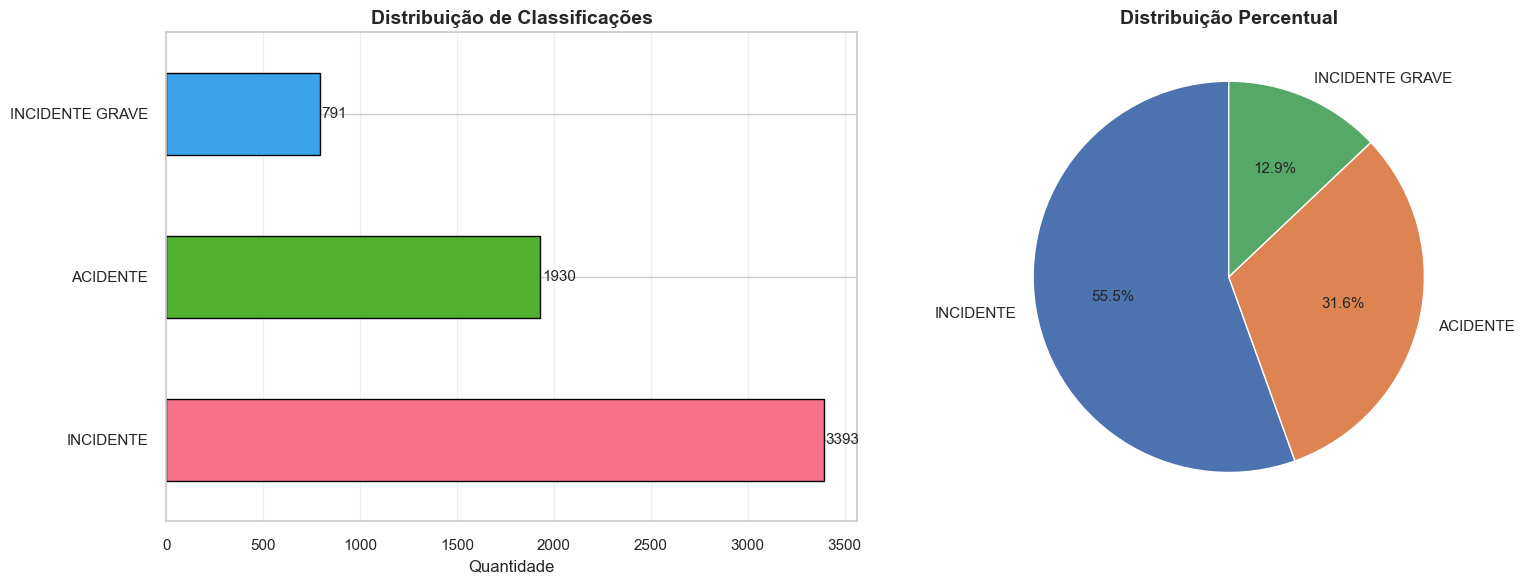

Classificacao da Ocorrencia 
INCIDENTE          3393
ACIDENTE           1930
INCIDENTE GRAVE     791
Name: count, dtype: int64


In [6]:
col_class = 'Classificacao da Ocorrencia ' if 'Classificacao da Ocorrencia ' in df.columns else 'Classificacao da Ocorrencia'
classificacoes = df[col_class].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Barras
classificacoes.plot(kind='barh', ax=ax1, color=sns.color_palette("husl", len(classificacoes)), edgecolor='black')
ax1.set_title('Distribuição de Classificações', fontsize=14, fontweight='bold')
ax1.set_xlabel('Quantidade', fontsize=12)
ax1.set_ylabel('')
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(classificacoes.values):
    ax1.text(v + 10, i, str(v), va='center', fontsize=11)

# Pizza
classificacoes.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 11})
ax2.set_title('Distribuição Percentual', fontsize=14, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

print(classificacoes)


### Interpretação

**Por que estes gráficos?** 
- **Gráfico de barras horizontal:** Facilita a leitura de categorias com nomes longos
- **Gráfico de pizza:** Mostra a proporção relativa do total, útil para entender a divisão percentual

**Resultado:** 
- Revela qual classificação (incidente, acidente, etc.) é mais frequente
- Mostra se há um tipo dominante ou distribuição equilibrada entre categorias
- Ajuda a entender o perfil geral dos eventos aeronáuticos

**Insight:** Se um tipo de ocorrência é predominante, esforços de prevenção devem ser focados naquele tipo específico.

## 5. Ocorrências por Estado


C:\Users\lucas\AppData\Local\Temp\ipykernel_5680\2132478389.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=ocorrencias_uf.values, y=ocorrencias_uf.index, orient='h', palette='viridis')


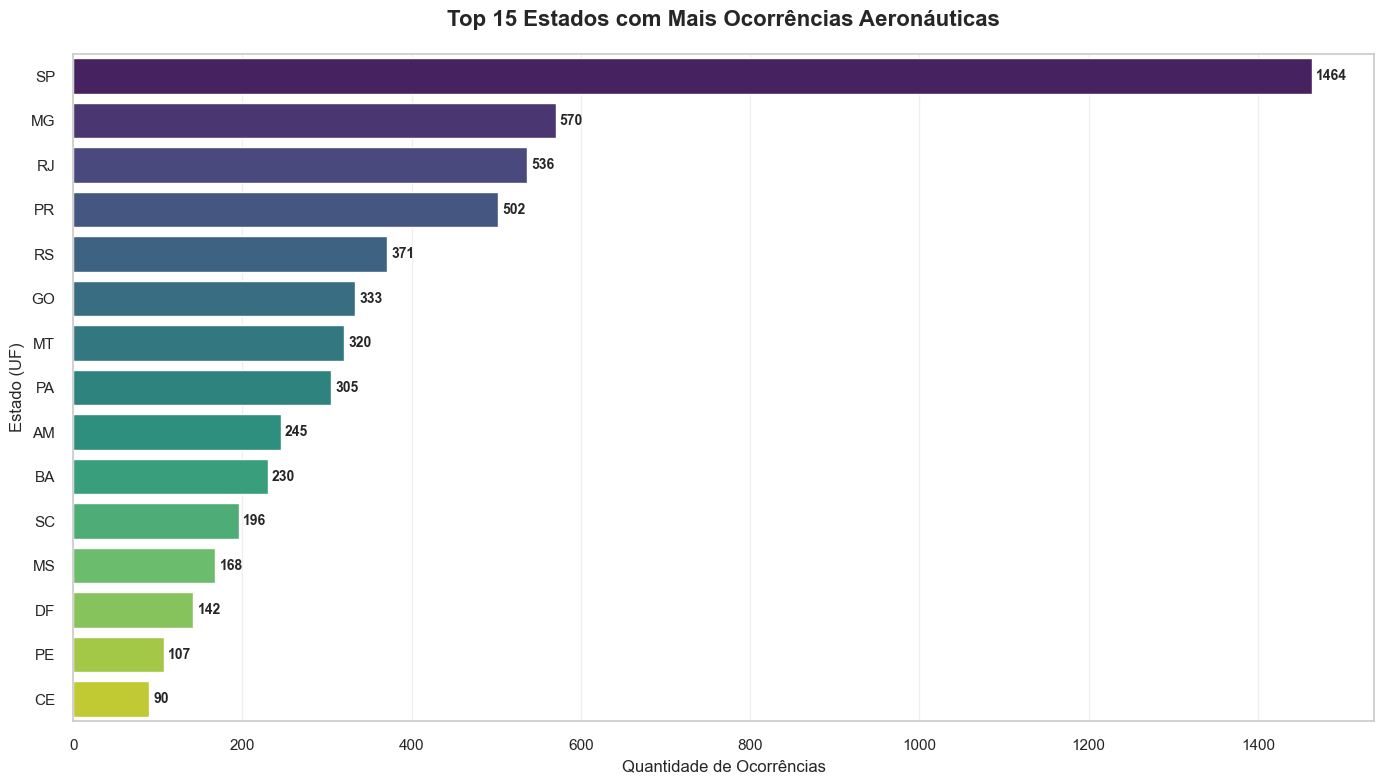

Estado com mais ocorrências: SP (1464 ocorrências)


In [7]:
ocorrencias_uf = df['UF da Ocorrencia'].value_counts().head(15)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x=ocorrencias_uf.values, y=ocorrencias_uf.index, orient='h', palette='viridis')

for i, v in enumerate(ocorrencias_uf.values):
    ax.text(v + 5, i, str(v), va='center', fontsize=10, fontweight='bold')

plt.title('Top 15 Estados com Mais Ocorrências Aeronáuticas', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Quantidade de Ocorrências', fontsize=12)
plt.ylabel('Estado (UF)', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Estado com mais ocorrências: {ocorrencias_uf.index[0]} ({ocorrencias_uf.values[0]} ocorrências)")


### Interpretação

**Por que este gráfico?** Um gráfico de barras horizontal com top 15 identifica geograficamente onde os acidentes são mais frequentes. Facilita a leitura de códigos de estado/UF.

**Resultado:** 
- Mostra distribuição geográfica dos acidentes
- Identifica regiões ou estados com maior concentração de ocorrências
- Pode correlacionar com densidade populacional, volume de voos ou infraestrutura aeronáutica

**Insight:** Estados com mais ocorrências podem ter:
- Maior movimento aeroportuário
- Rotas mais congestionadas
- Possíveis deficiências em infraestrutura ou regulação local
- Necessidade de reforço em medidas preventivas específicas

## 6. Tipos de Ocorrências Mais Frequentes


C:\Users\lucas\AppData\Local\Temp\ipykernel_5680\3796997615.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=tipos_ocorrencia.values, y=tipos_ocorrencia.index, orient='h', palette='rocket', edgecolor='black')


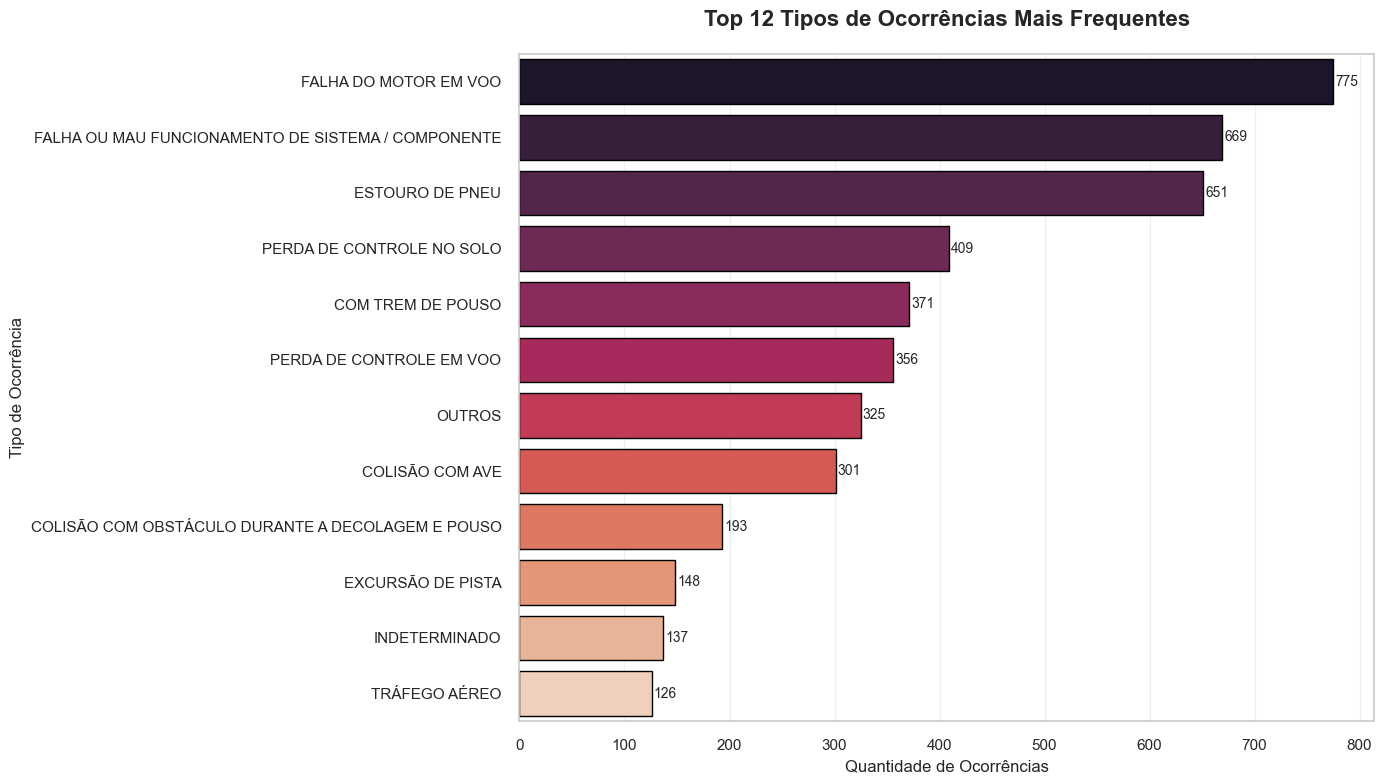

Tipo mais comum: FALHA DO MOTOR EM VOO (775 ocorrências - 12.7% do total)


In [8]:
tipos_ocorrencia = df['Tipo de Ocorrencia'].value_counts().head(12)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x=tipos_ocorrencia.values, y=tipos_ocorrencia.index, orient='h', palette='rocket', edgecolor='black')

for i, v in enumerate(tipos_ocorrencia.values):
    ax.text(v + 2, i, str(v), va='center', fontsize=10)

plt.title('Top 12 Tipos de Ocorrências Mais Frequentes', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Quantidade de Ocorrências', fontsize=12)
plt.ylabel('Tipo de Ocorrência', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Tipo mais comum: {tipos_ocorrencia.index[0]} ({tipos_ocorrencia.values[0]} ocorrências - {tipos_ocorrencia.values[0]/len(df)*100:.1f}% do total)")


### Interpretação

**Por que este gráfico?** Um gráfico de barras horizontal com top 12 permite visualizar os tipos de ocorrências mais frequentes de forma clara e comparável.

**Resultado:**
- Identifica os tipos de acidentes mais comuns (colisão, pane, pouso forçado, etc.)
- Mostra o padrão mais repetido nos eventos aeronáuticos
- Permite priorização de pesquisas e medidas preventivas

**Insight:** Se um tipo específico de ocorrência representa mais de 20-30% do total, indica que:
- Existe um padrão comum de falha
- As causas podem ser similares
- Esforços de prevenção devem focar neste tipo
- Pode ser oportunidade para intervenção altamente efetiva

## 7. Análise de Fatalidades


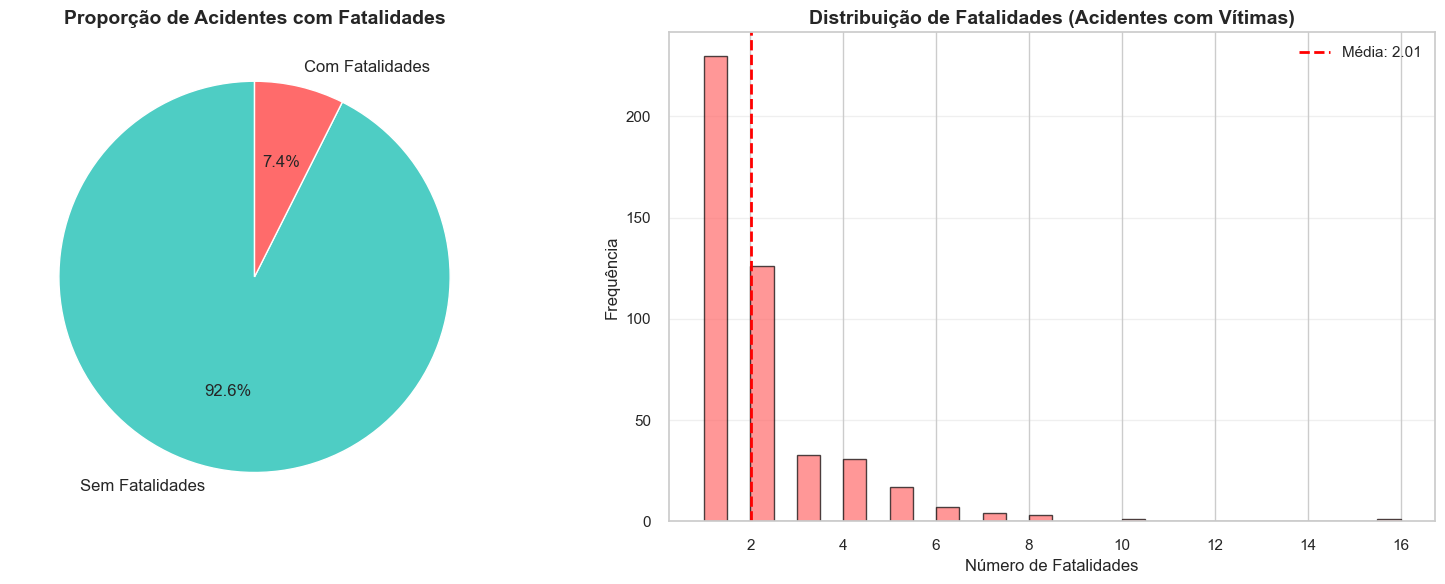

Total de acidentes: 6114
Acidentes com fatalidades: 453 (7.41%)
Acidentes sem fatalidades: 5661 (92.59%)
Média de fatalidades (quando há vítimas): 2.01
Máximo de fatalidades em um acidente: 16


In [9]:
df['Total de Fatalidades no Acidente'] = pd.to_numeric(df['Total de Fatalidades no Acidente'], errors='coerce')

com_fatalidades = (df['Total de Fatalidades no Acidente'] > 0).sum()
sem_fatalidades = (df['Total de Fatalidades no Acidente'] == 0).sum()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pizza
axes[0].pie([sem_fatalidades, com_fatalidades], labels=['Sem Fatalidades', 'Com Fatalidades'],
           autopct='%1.1f%%', startangle=90, colors=['#4ECDC4', '#FF6B6B'], textprops={'fontsize': 12})
axes[0].set_title('Proporção de Acidentes com Fatalidades', fontsize=14, fontweight='bold')

# Histograma
fatalidades_validas = df[df['Total de Fatalidades no Acidente'] > 0]['Total de Fatalidades no Acidente']
axes[1].hist(fatalidades_validas, bins=30, color='#FF6B6B', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribuição de Fatalidades (Acidentes com Vítimas)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Número de Fatalidades', fontsize=12)
axes[1].set_ylabel('Frequência', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)
axes[1].axvline(fatalidades_validas.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Média: {fatalidades_validas.mean():.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Total de acidentes: {len(df)}")
print(f"Acidentes com fatalidades: {com_fatalidades} ({com_fatalidades/len(df)*100:.2f}%)")
print(f"Acidentes sem fatalidades: {sem_fatalidades} ({sem_fatalidades/len(df)*100:.2f}%)")
print(f"Média de fatalidades (quando há vítimas): {fatalidades_validas.mean():.2f}")
print(f"Máximo de fatalidades em um acidente: {df['Total de Fatalidades no Acidente'].max():.0f}")


### Interpretação

**Por que estes gráficos?**
- **Gráfico de pizza:** Mostra proporção de eventos com/sem vítimas de forma intuitiva
- **Histograma:** Revela a distribuição e frequência do número de fatalidades nos acidentes graves

**Resultado:**
- Identifica quantos acidentes resultam em fatalidades (severidade)
- Mostra a distribuição de vítimas quando há fatalidades
- Média e máximo indicam a gravidade típica

**Insight:** 
- Alta porcentagem de acidentes SEM fatalidades indica boa segurança estrutural
- A média de fatalidades (quando há) mostra a severidade típica dos acidentes
- Outliers (picos no histograma) indicam magnitudes catastróficas específicas
- Necessário investigar acidentes com altíssimo número de vítimas para evitar repetição

## 8. Fases de Operação com Mais Ocorrências


C:\Users\lucas\AppData\Local\Temp\ipykernel_5680\3306242823.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=fases.values, y=fases.index, orient='h', palette='mako', edgecolor='black')


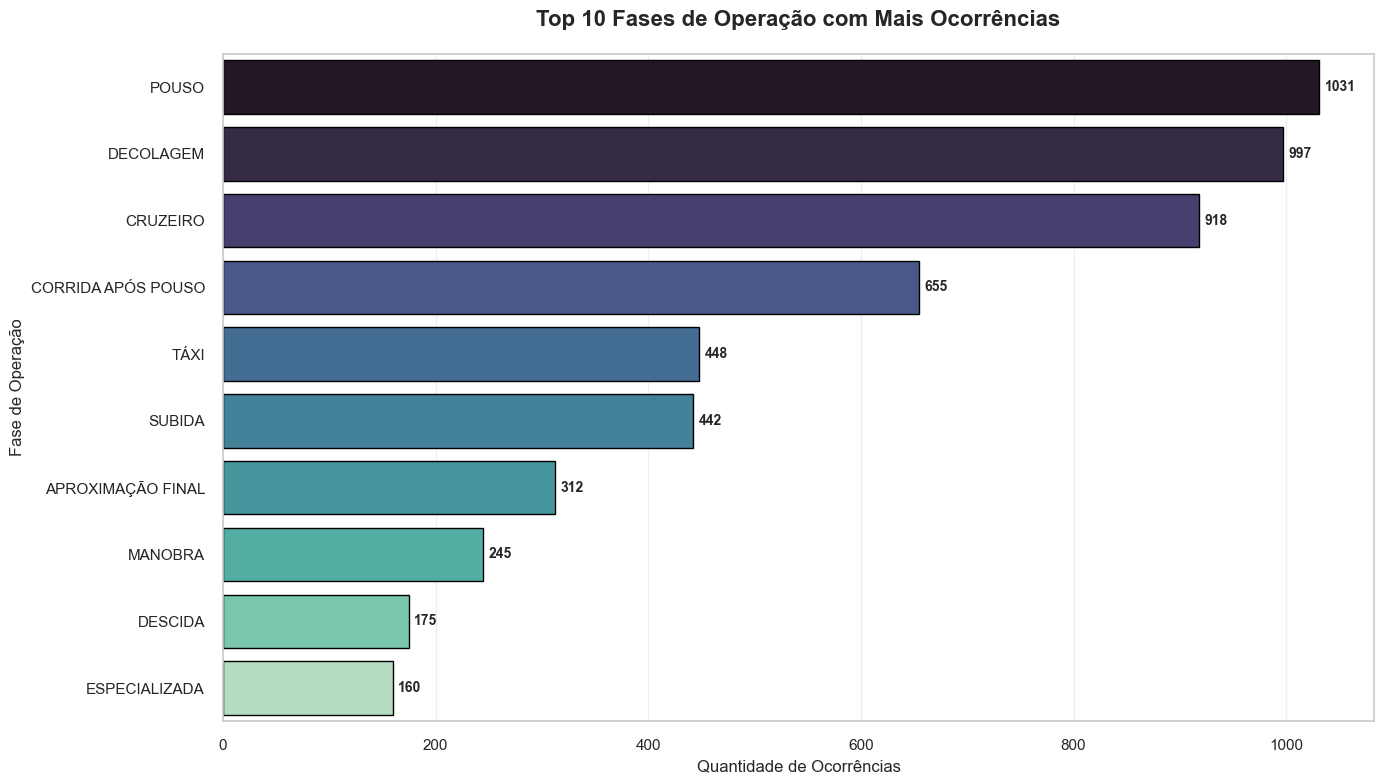

Fase mais crítica: POUSO (1031 ocorrências - 16.9% do total)


In [10]:
fases = df['Fase de Operacao da Aeronave'].value_counts().head(10)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x=fases.values, y=fases.index, orient='h', palette='mako', edgecolor='black')

for i, v in enumerate(fases.values):
    ax.text(v + 5, i, str(v), va='center', fontsize=10, fontweight='bold')

plt.title('Top 10 Fases de Operação com Mais Ocorrências', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Quantidade de Ocorrências', fontsize=12)
plt.ylabel('Fase de Operação', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Fase mais crítica: {fases.index[0]} ({fases.values[0]} ocorrências - {fases.values[0]/len(df)*100:.1f}% do total)")


### Interpretação

**Por que este gráfico?** Um gráfico de barras horizontal identifica em quais fases da operação (decolagem, voo, pouso, etc.) os acidentes ocorrem mais frequentemente.

**Resultado:**
- Mostra as fases mais críticas de uma operação aérea
- Identifica pontos vulneráveis no ciclo de voo
- Permite alocação de recursos preventivos nas fases de maior risco

**Insight:** 
- Se pouso tem mais acidentes, pode indicar problemas com pistas, visibilidade ou procedimentos
- Decolagem crítica pode indicar problemas com carga de combustível ou condições climáticas
- Voo em rota pode revelar problemas de navegação ou comunicação
- Foco em treinamento e protocolos para a fase mais crítica pode reduzir significativamente os acidentes

## 9. Tipos de Aeronaves Envolvidas


C:\Users\lucas\AppData\Local\Temp\ipykernel_5680\820001878.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=tipos_aeronave.values, y=tipos_aeronave.index, orient='h', palette='viridis', edgecolor='black')


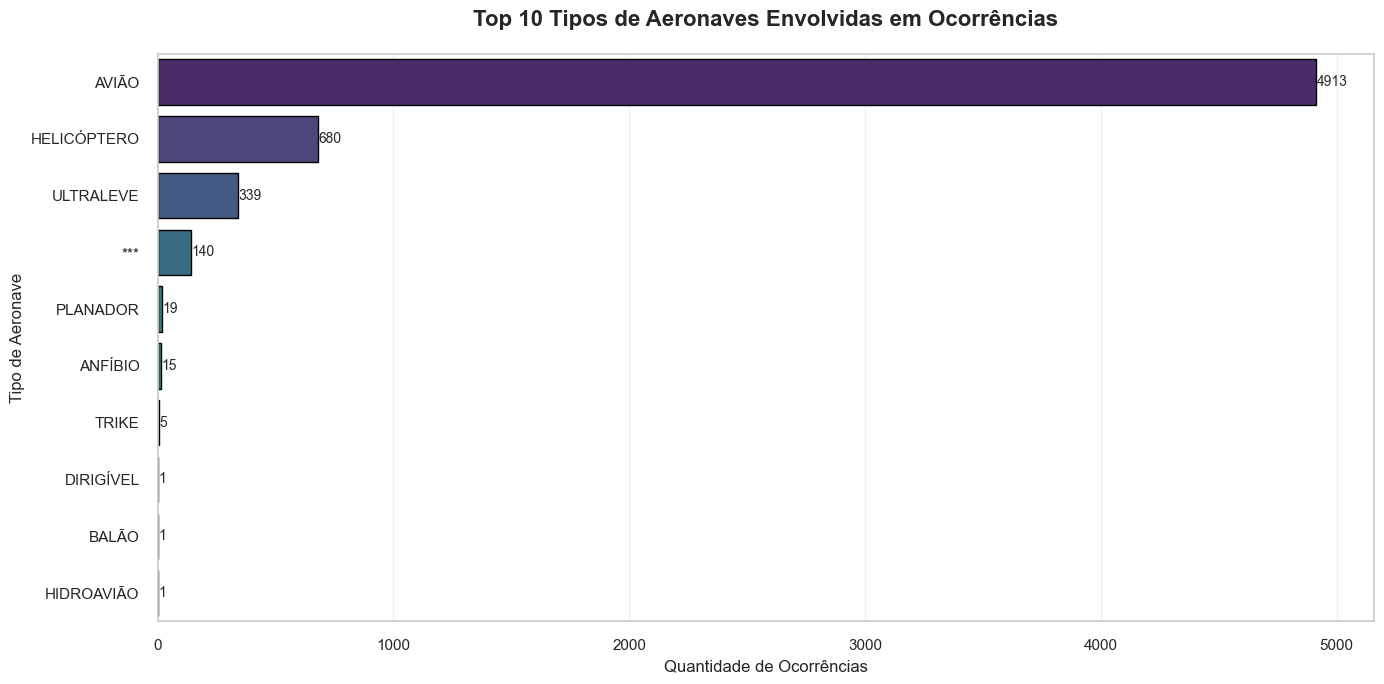

Tipo mais envolvido: AVIÃO (4913 ocorrências)


In [11]:
tipos_aeronave = df['Tipo de Aeronave'].value_counts().head(10)

plt.figure(figsize=(14, 7))
ax = sns.barplot(x=tipos_aeronave.values, y=tipos_aeronave.index, orient='h', palette='viridis', edgecolor='black')

for i, v in enumerate(tipos_aeronave.values):
    ax.text(v + 3, i, str(v), va='center', fontsize=10)

plt.title('Top 10 Tipos de Aeronaves Envolvidas em Ocorrências', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Quantidade de Ocorrências', fontsize=12)
plt.ylabel('Tipo de Aeronave', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Tipo mais envolvido: {tipos_aeronave.index[0]} ({tipos_aeronave.values[0]} ocorrências)")


### Interpretação

**Por que este gráfico?** Um gráfico de barras horizontal com top 10 mostra quais modelos/tipos de aeronaves estão envolvidos em mais ocorrências.

**Resultado:**
- Identifica se certos tipos de aeronaves são mais propensos a acidentes
- Pode indicar problemas de design, manutenção ou operação específicos
- Revela padrões por modelo de aeronave

**Insight:**
- Aeronaves mais antigas podem ter mais acidentes (desgaste)
- Aeronaves com maior volume operacional naturalmente aparecem mais
- Tipos específicos recorrentes podem indicar:
  - Falhas conhecidas que precisam correção
  - Problemas de treinamento de piloto para aquele tipo
  - Necessidade de programa de inspeção intensiva
  - Possível necessidade de aposentação da frota

## 10. Fase de Operação vs Nível de Dano


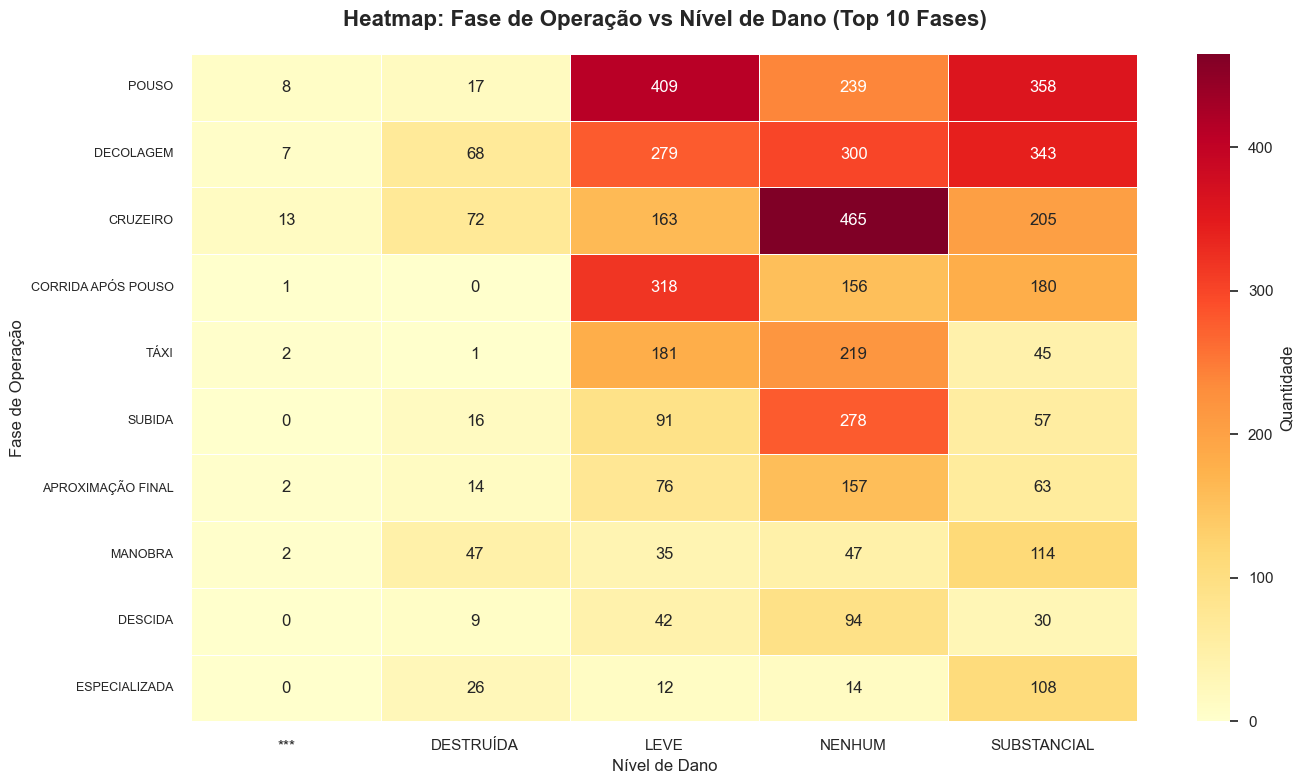

Células mais escuras indicam maior concentração de ocorrências.


In [12]:
fase_dano = df.groupby(['Fase de Operacao da Aeronave', 'Nivel de Dano da Aeronave']).size().reset_index(name='Quantidade')
pivot_fase_dano = fase_dano.pivot(index='Fase de Operacao da Aeronave', columns='Nivel de Dano da Aeronave', values='Quantidade').fillna(0)

# Top 10 fases
pivot_fase_dano['Total'] = pivot_fase_dano.sum(axis=1)
pivot_fase_dano = pivot_fase_dano.sort_values('Total', ascending=False).head(10).drop('Total', axis=1)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_fase_dano, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Quantidade'}, linewidths=0.5)
plt.title('Heatmap: Fase de Operação vs Nível de Dano (Top 10 Fases)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Nível de Dano', fontsize=12)
plt.ylabel('Fase de Operação', fontsize=12)
plt.tick_params(axis='y', labelsize=9)
plt.tight_layout()
plt.show()

print("Células mais escuras indicam maior concentração de ocorrências.")


### Interpretação

**Por que este gráfico?** Um heatmap (mapa de calor) é excelente para mostrar a relação entre duas variáveis categóricas simultaneamente. As cores representam frequência, facilitando a identificação de padrões.

**Resultado:**
- Mostra em quais fases ocorrem os maiores danos
- Identifica combinações críticas (ex: pouso com dano total)
- Revela se certos danos são concentrados em fases específicas

**Insight:**
- Células mais escuras (vermelhas) indicam as combinações mais críticas
- Se pouso tem muitos danos estruturais = problema em procedimentos de pouso
- Se certos danos só ocorrem em fases específicas = ponto vulnerável identificado
- Padrões uniformes podem indicar distribuição aleatória vs padrões concentrados
- Ações preventivas podem ser direcionadas às combinações mais perigosas

## 11. Relação Idade da Aeronave vs Fatalidades


C:\Users\lucas\AppData\Local\Temp\ipykernel_5680\2762581920.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_aeronave, x='Faixa_Idade', y='Total de Fatalidades no Acidente', palette='coolwarm')


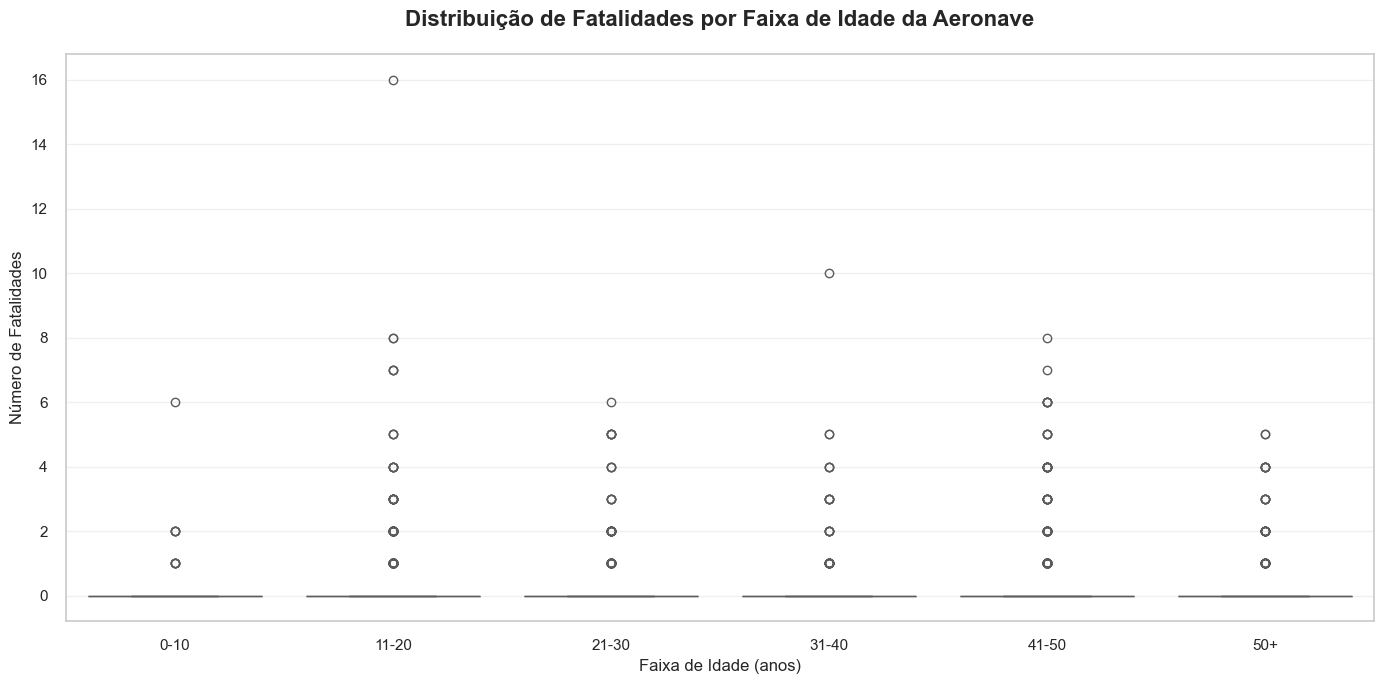

Média de fatalidades por faixa de idade:
                 mean  count
Faixa_Idade                 
41-50        0.190369   1329
50+          0.180680    559
21-30        0.164160    798
11-20        0.133999   1903
0-10         0.133803    142
31-40        0.089286    896


C:\Users\lucas\AppData\Local\Temp\ipykernel_5680\2762581920.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  idade_fatal = df_aeronave.groupby('Faixa_Idade')['Total de Fatalidades no Acidente'].agg(['mean', 'count'])


In [13]:
df['Ano de Fabricacao da Aeronave'] = pd.to_numeric(df['Ano de Fabricacao da Aeronave'], errors='coerce')
df_aeronave = df[(df['Ano de Fabricacao da Aeronave'].notna()) & 
                 (df['Ano de Fabricacao da Aeronave'] > 1900) &
                 (df['Ano de Fabricacao da Aeronave'] <= 2024) &
                 (df['Total de Fatalidades no Acidente'].notna())].copy()

df_aeronave['Idade_Aeronave'] = 2024 - df_aeronave['Ano de Fabricacao da Aeronave']
df_aeronave['Faixa_Idade'] = pd.cut(df_aeronave['Idade_Aeronave'], 
                                    bins=[0, 10, 20, 30, 40, 50, 100],
                                    labels=['0-10', '11-20', '21-30', '31-40', '41-50', '50+'])

plt.figure(figsize=(14, 7))
sns.boxplot(data=df_aeronave, x='Faixa_Idade', y='Total de Fatalidades no Acidente', palette='coolwarm')
plt.title('Distribuição de Fatalidades por Faixa de Idade da Aeronave', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Faixa de Idade (anos)', fontsize=12)
plt.ylabel('Número de Fatalidades', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

idade_fatal = df_aeronave.groupby('Faixa_Idade')['Total de Fatalidades no Acidente'].agg(['mean', 'count'])
print("Média de fatalidades por faixa de idade:")
print(idade_fatal.sort_values('mean', ascending=False))


### Interpretação

**Por que este gráfico?** Um boxplot é ideal para comparar distribuições entre grupos. Mostra mediana, quartis e outliers simultaneamente, revelando diferenças nas distribuições de fatalidades por faixa etária da aeronave.

**Resultado:**
- Mostra se aeronaves mais antigas têm mais vítimas
- Identifica faixas de idade com maior risco
- Boxplot revela:
  - Linha no meio = mediana de fatalidades
  - Caixa = 50% dos casos
  - "Bigodes" = amplitude típica
  - Pontos = casos extremos (outliers)

**Insight:**
- Tendência de aumento com idade = desgaste pode ser fator
- Comportamento constante = idade não é determinante principal
- Outliers indicam acidentes particularmente graves em certas faixas
- Aeronaves com idade acima de 40-50 anos podem justificar:
  - Programas de inspeção mais rigorosos
  - Retirada de operação
  - Reforço em manutenção preventiva
- Dados orientam políticas de renovação de frotas

## 12. Matriz de Correlação


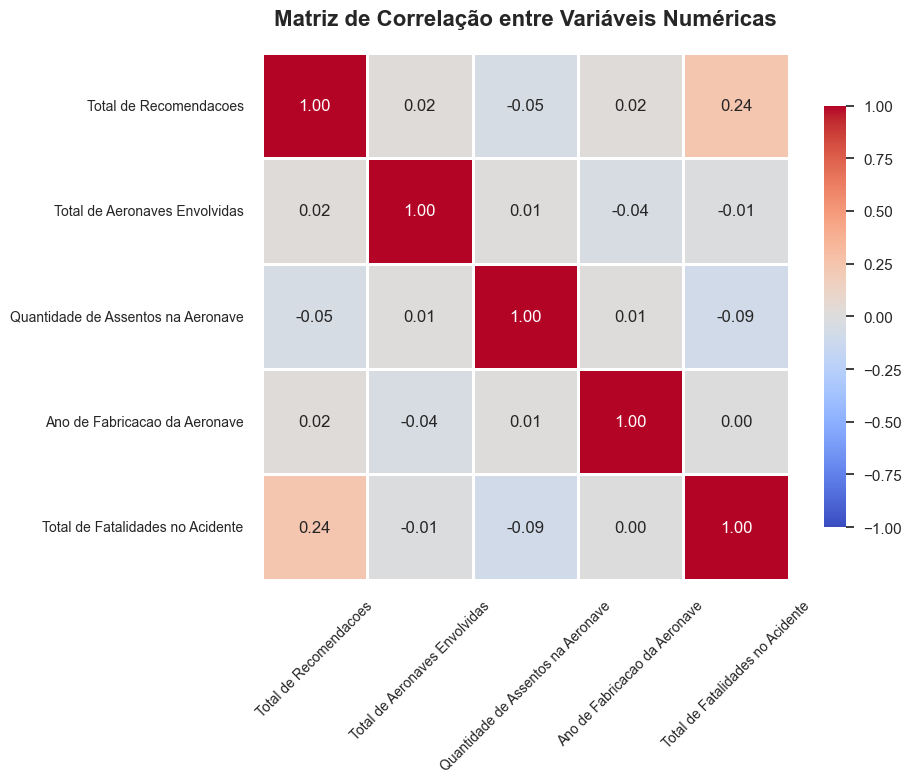

Valores próximos de +1 ou -1 indicam correlação forte.
Valores próximos de 0 indicam pouca ou nenhuma correlação.
                                    Total de Recomendacoes  \
Total de Recomendacoes                            1.000000   
Total de Aeronaves Envolvidas                     0.017344   
Quantidade de Assentos na Aeronave               -0.053921   
Ano de Fabricacao da Aeronave                     0.018431   
Total de Fatalidades no Acidente                  0.238955   

                                    Total de Aeronaves Envolvidas  \
Total de Recomendacoes                                   0.017344   
Total de Aeronaves Envolvidas                            1.000000   
Quantidade de Assentos na Aeronave                       0.014854   
Ano de Fabricacao da Aeronave                           -0.041893   
Total de Fatalidades no Acidente                        -0.009762   

                                    Quantidade de Assentos na Aeronave  \
Total de Recomendacoes  

In [14]:
# Preparando dados numéricos
colunas_numericas = ['Total de Recomendacoes', 'Total de Aeronaves Envolvidas',
                     'Quantidade de Assentos na Aeronave', 'Ano de Fabricacao da Aeronave',
                     'Total de Fatalidades no Acidente']

df_corr = df.copy()
for col in colunas_numericas:
    if col in df_corr.columns:
        df_corr[col] = pd.to_numeric(df_corr[col], errors='coerce')

colunas_existentes = [col for col in colunas_numericas if col in df_corr.columns]
df_corr_clean = df_corr[colunas_existentes].dropna()

if len(df_corr_clean.columns) > 1:
    matriz_corr = df_corr_clean.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
               square=True, linewidths=1, cbar_kws={"shrink": 0.8},
               vmin=-1, vmax=1)
    plt.title('Matriz de Correlação entre Variáveis Numéricas', fontsize=16, fontweight='bold', pad=20)
    plt.tick_params(axis='x', rotation=45, labelsize=10)
    plt.tick_params(axis='y', rotation=0, labelsize=10)
    plt.tight_layout()
    plt.show()
    
    print("Valores próximos de +1 ou -1 indicam correlação forte.")
    print("Valores próximos de 0 indicam pouca ou nenhuma correlação.")
    print(matriz_corr)
else:
    print("Dados insuficientes para análise de correlação.")


### Interpretação

**Por que este gráfico?** Uma matriz de correlação (heatmap) mostra relações entre variáveis numéricas. Correlação forte indica que variáveis se movem juntas, ajudando a identificar causas ou relacionamentos casuais.

**Resultado:**
- **Cores vermelhas (próximo a +1)** = correlação positiva forte (quando uma aumenta, a outra também)
- **Cores azuis (próximo a -1)** = correlação negativa forte (quando uma aumenta, a outra diminui)
- **Cores brancas (próximo a 0)** = pouca ou nenhuma correlação

**Exemplos de Insights:**
- Se fatalidades correlacionam com aeronaves envolvidas = mais aeronaves = mais vítimas (esperado)
- Se fatalidades correlacionam com assentos = aviões maiores têm mais vítimas (capacidade)
- Se recomendações correlacionam com fatalidades = acidentes graves geram mais ações corretivas
- Correlação negativa entre recomendações e acidentes = mais recomendações = menos acidentes (efetividade)

**Ação:** Correlações fortes identificam relacionamentos para investigação causal e orientam decisões de segurança.

## 13. Relação entre Tipos de Ocorrências e Indicadores de Severidade

In [15]:
# Preparando dados
df_sev = df.copy()
df_sev['Total de Fatalidades no Acidente'] = pd.to_numeric(df_sev['Total de Fatalidades no Acidente'], errors='coerce')
df_sev['Total de Recomendacoes'] = pd.to_numeric(df_sev['Total de Recomendacoes'], errors='coerce')

# Análise por tipo de ocorrência
severidade_tipo = df_sev.groupby('Tipo de Ocorrencia').agg({
    'Total de Fatalidades no Acidente': ['mean', 'count'],
    'Total de Recomendacoes': 'mean'
}).round(2)

severidade_tipo.columns = ['Fatalidades_Media', 'Total_Ocorrencias', 'Recomendacoes_Media']
severidade_tipo = severidade_tipo[severidade_tipo['Total_Ocorrencias'] >= 5].sort_values('Fatalidades_Media', ascending=False).head(15)

print(severidade_tipo)


                                                   Fatalidades_Media  \
Tipo de Ocorrencia                                                     
VOO CONTROLADO CONTRA O TERRENO                                 1.98   
FALHA ESTRUTURAL                                                1.45   
DESORIENTAÇÃO ESPACIAL                                          1.30   
PERDA DE CONTROLE EM VOO                                        0.86   
INDETERMINADO                                                   0.77   
COLISÃO DE AERONAVES EM VOO                                     0.55   
COLISÃO COM OBSTÁCULO DURANTE A DECOLAGEM E POUSO               0.36   
OPERAÇÃO A BAIXA ALTITUDE                                       0.27   
COM ROTOR                                                       0.25   
PANE SECA                                                       0.25   
COM COMANDOS DE VOO                                             0.25   
COMBUSTÍVEL                                                     

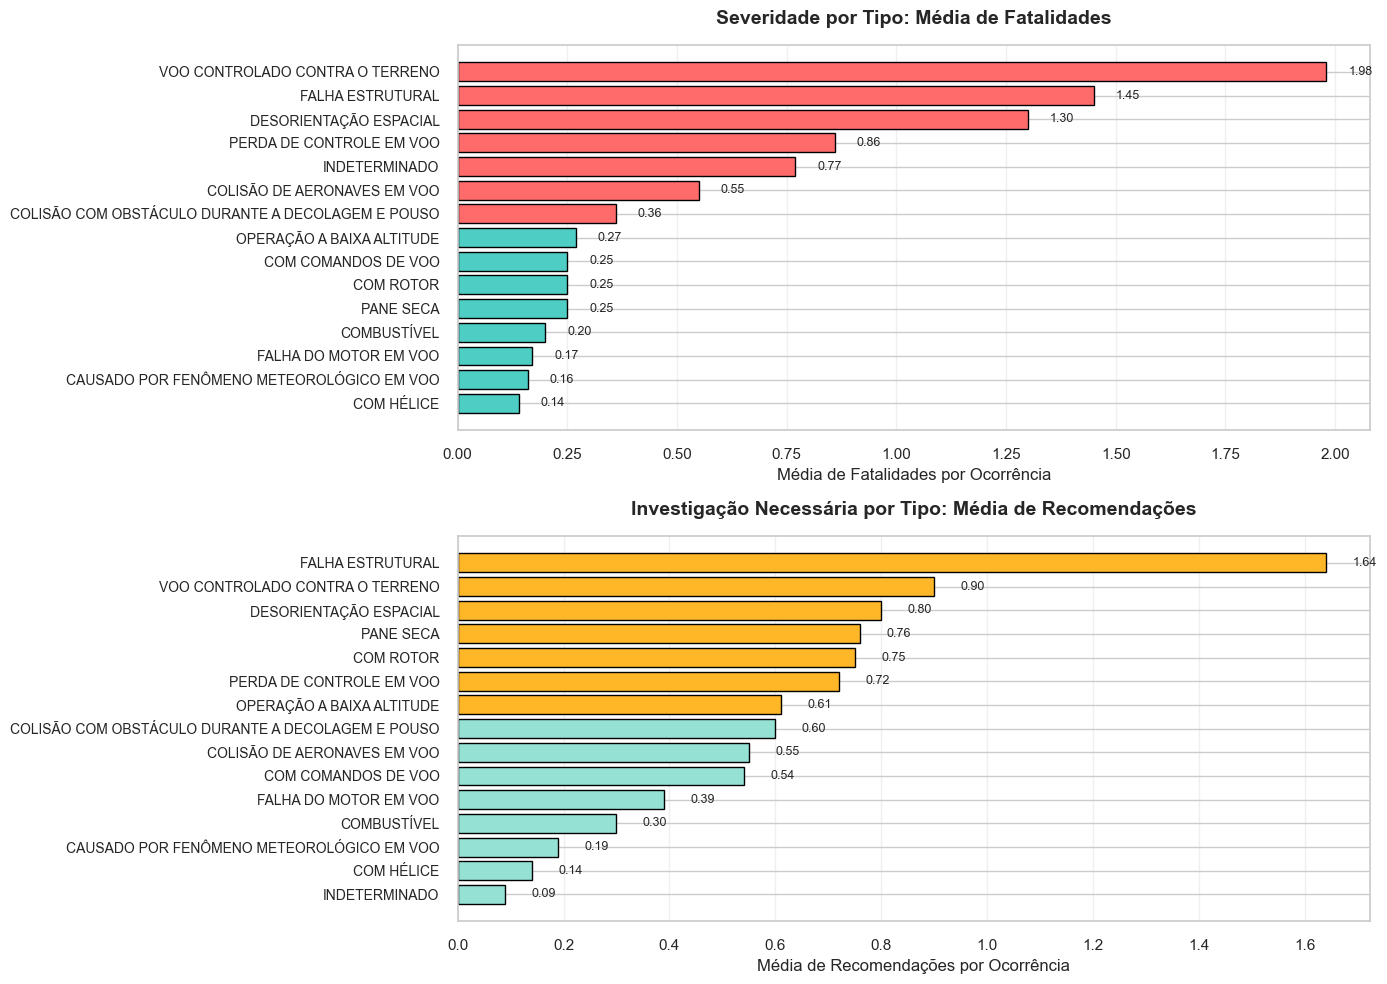


RESUMO: Tipos de Ocorrência Mais Críticos
                                                   Fatalidades_Media  \
Tipo de Ocorrencia                                                     
VOO CONTROLADO CONTRA O TERRENO                                 1.98   
FALHA ESTRUTURAL                                                1.45   
DESORIENTAÇÃO ESPACIAL                                          1.30   
PERDA DE CONTROLE EM VOO                                        0.86   
INDETERMINADO                                                   0.77   
COLISÃO DE AERONAVES EM VOO                                     0.55   
COLISÃO COM OBSTÁCULO DURANTE A DECOLAGEM E POUSO               0.36   
OPERAÇÃO A BAIXA ALTITUDE                                       0.27   
COM ROTOR                                                       0.25   
PANE SECA                                                       0.25   
COM COMANDOS DE VOO                                             0.25   
COMBUSTÍVEL          

In [16]:
# Gráfico 1: Fatalidades Médias por Tipo de Ocorrência
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Barras - Fatalidades
severidade_plot = severidade_tipo.sort_values('Fatalidades_Media', ascending=True)
colors_fat = ['#FF6B6B' if x > severidade_tipo['Fatalidades_Media'].median() else '#4ECDC4' 
              for x in severidade_plot['Fatalidades_Media']]

axes[0].barh(range(len(severidade_plot)), severidade_plot['Fatalidades_Media'], color=colors_fat, edgecolor='black')
axes[0].set_yticks(range(len(severidade_plot)))
axes[0].set_yticklabels(severidade_plot.index, fontsize=10)
axes[0].set_xlabel('Média de Fatalidades por Ocorrência', fontsize=12)
axes[0].set_title('Severidade por Tipo: Média de Fatalidades', fontsize=14, fontweight='bold', pad=15)
axes[0].grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(severidade_plot.iterrows()):
    axes[0].text(row['Fatalidades_Media'] + 0.05, i, f"{row['Fatalidades_Media']:.2f}", va='center', fontsize=9)

# Barras - Recomendações
severidade_rec = severidade_tipo.sort_values('Recomendacoes_Media', ascending=True)
colors_rec = ['#FFB627' if x > severidade_tipo['Recomendacoes_Media'].median() else '#95E1D3' 
              for x in severidade_rec['Recomendacoes_Media']]

axes[1].barh(range(len(severidade_rec)), severidade_rec['Recomendacoes_Media'], color=colors_rec, edgecolor='black')
axes[1].set_yticks(range(len(severidade_rec)))
axes[1].set_yticklabels(severidade_rec.index, fontsize=10)
axes[1].set_xlabel('Média de Recomendações por Ocorrência', fontsize=12)
axes[1].set_title('Investigação Necessária por Tipo: Média de Recomendações', fontsize=14, fontweight='bold', pad=15)
axes[1].grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(severidade_rec.iterrows()):
    axes[1].text(row['Recomendacoes_Media'] + 0.05, i, f"{row['Recomendacoes_Media']:.2f}", va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("RESUMO: Tipos de Ocorrência Mais Críticos")
print("="*70)
print(severidade_tipo)


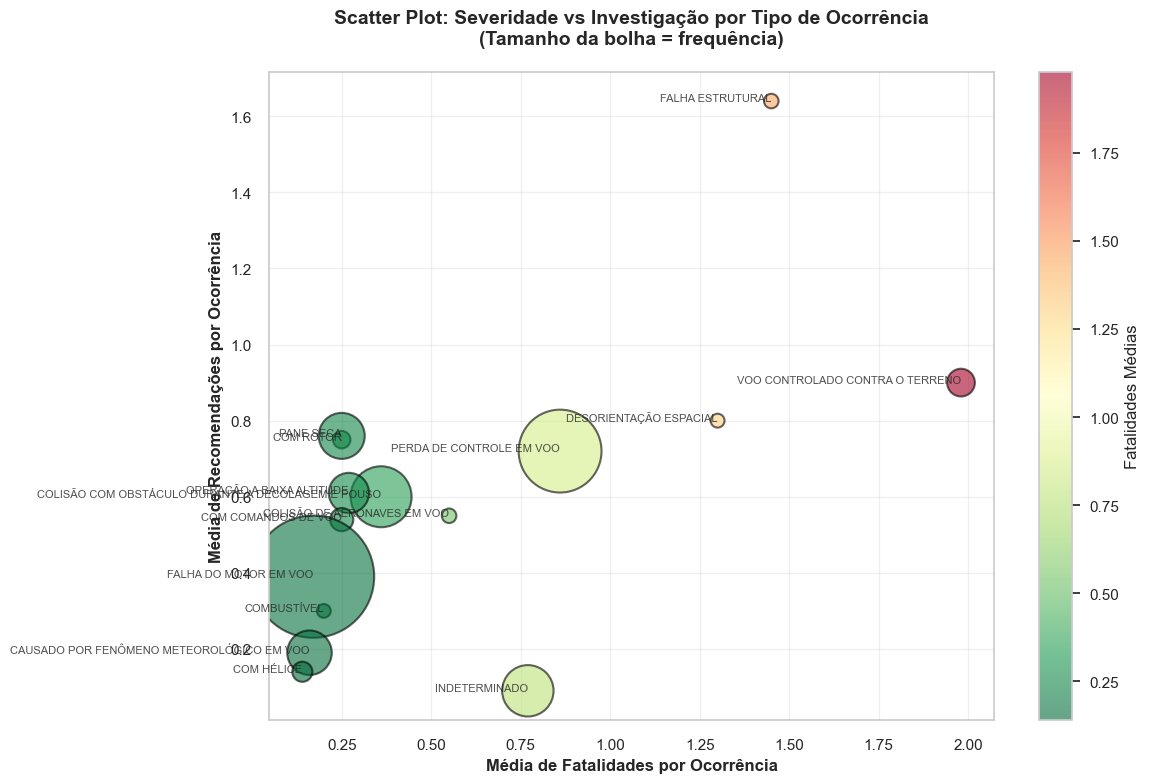

Tamanho da bolha = quantidade de ocorrências do tipo
Posição horizontal = severidade em vidas perdidas
Posição vertical = quantidade de investigação necessária


In [17]:
# Scatter Plot: Relação entre Fatalidades e Recomendações
plt.figure(figsize=(12, 8))

# Criar scatter plot
scatter = plt.scatter(severidade_tipo['Fatalidades_Media'], 
                     severidade_tipo['Recomendacoes_Media'],
                     s=severidade_tipo['Total_Ocorrencias']*10,
                     alpha=0.6,
                     c=severidade_tipo['Fatalidades_Media'],
                     cmap='RdYlGn_r',
                     edgecolors='black',
                     linewidth=1.5)

# Adicionar labels para cada ponto
for idx, row in severidade_tipo.iterrows():
    plt.annotate(idx, 
                (row['Fatalidades_Media'], row['Recomendacoes_Media']),
                fontsize=8,
                alpha=0.8,
                ha='right')

plt.xlabel('Média de Fatalidades por Ocorrência', fontsize=12, fontweight='bold')
plt.ylabel('Média de Recomendações por Ocorrência', fontsize=12, fontweight='bold')
plt.title('Scatter Plot: Severidade vs Investigação por Tipo de Ocorrência\n(Tamanho da bolha = frequência)', 
         fontsize=14, fontweight='bold', pad=20)
plt.colorbar(scatter, label='Fatalidades Médias')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Tamanho da bolha = quantidade de ocorrências do tipo")
print("Posição horizontal = severidade em vidas perdidas")
print("Posição vertical = quantidade de investigação necessária")


### Interpretação

**Por que esta análise?** Combina dados **categóricos** (tipos de ocorrências) com dados **numéricos** (fatalidades e recomendações), convertendo categorias em métricas mensuráveis. Isso permite ver qual tipo de ocorrência é mais perigoso e qual requer mais investigação.

**Resultado dos Gráficos:**

**Gráfico 1 - Fatalidades por Tipo:**
- Cores **vermelhas** = acima da média = tipos críticos em vidas perdidas
- Cores **azuis** = abaixo da média = tipos menos letais
- Identifica quais tipos de ocorrência causam mais mortes por evento

**Gráfico 2 - Recomendações por Tipo:**
- Cores **laranja** = acima da média = tipos que demandam mais investigação
- Cores **turquesa** = abaixo da média = tipos com investigação simples
- Mostra complexidade de análise e necessidade de ações corretivas

**Gráfico 3 - Scatter Plot (Relação Fatalidades vs Recomendações):**
- **Bolhas grandes, à direita e acima** = CRÍTICO: muitas fatalidades E muitas recomendações = prioridade máxima
- **Bolhas grandes, à esquerda e acima** = COMPLEXO: poucas vítimas mas muitas recomendações = problemas multifatoriais
- **Bolhas grandes, à direita e abaixo** = LETAL mas SIMPLES: muitas vítimas, poucas recomendações = causa óbvia, solução direta
- **Bolhas pequenas** = ocorrências raras ou de pouca severidade

**Insight Estratégico:**
1. Tipos no quadrante superior direito = máxima prioridade de intervenção
2. Tipos com muitas recomendações = problemas complexos, múltiplas causas, requerem recursos maiores
3. Tipos com poucas recomendações mas letais = causa bem identificada, solução pode ser simples e eficaz
4. Frequência (tamanho da bolha) mostra impacto real = bolha grande = afeta mais casos